# Late Delivery Predictions 

## OBJECTIVES


## Import all the required libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn import model_selection
import seaborn as sns
from collections import Counter
import imblearn
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error, confusion_matrix
from imblearn.under_sampling import NearMiss
from category_encoders import LeaveOneOutEncoder
import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [2]:
customer_df = pd.read_csv('./db/olist_customers_dataset.csv',header= 0,encoding='unicode_escape')
order_df = pd.read_csv('./db/olist_orders_dataset.csv',header= 0,encoding='unicode_escape')
order_items_df = pd.read_csv('./db/olist_order_items_dataset.csv',header= 0,encoding='unicode_escape')
products_df = pd.read_csv('./db/olist_products_dataset.csv',header= 0,encoding='unicode_escape')
sellers_df = pd.read_csv('./db/olist_sellers_dataset.csv',header= 0,encoding='unicode_escape')
order_payments_df = pd.read_csv('./db/olist_order_payments_dataset.csv',header= 0,encoding='unicode_escape')

pd.set_option('display.max_columns',None)


## Key Functions
#### Those are the key functions that I am going to use throughout my analysis

In [3]:
# This function provide basicInformations of the passing dataframe. 
def basicInfo(df):
    print('Total data-points :',df.size)
    print('Total features: ',df.shape[1])
    numerical_features = [f for f in df.columns if df[f].dtypes!='O']
    print('Total numerical features :',len(numerical_features))
    cat_features = [c for c in df.columns if df[c].dtypes=='O']
    print('Total categorical features :',len(cat_features))
    print('Total rows: ',df.shape[0])
    print("\nFeature lists containing null values in percentage:\n")
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            print(column, ': {:.4%}'.format(df[column].isnull().sum() / df[column].shape[0]))

# This function draw heatmap. 
def heatMap(df_heatmap):
    ftr_corr = df_heatmap.corr()
    top_corr=ftr_corr.index
    plt.figure(figsize=(20,15))
    g=sns.heatmap(df_heatmap[top_corr].corr(),annot=True)
    df_heatmap.columns.tolist()

# This function draw pieChart. 
def pieChart(feature_df,feature_title):
    order_status_ = feature_df.value_counts()
    order_status_label_ = order_status_.keys()
    plt.figure(figsize=(10,10))
    plt.pie(order_status_,labels=order_status_label_,autopct='%1.2f%%')
    plt.legend(title=feature_title)
    plt.show()
    
# This function return all features. 
def getFtrs(df):
    return df.columns.tolist()

# This function return categorical features. 
def getCtgCols(df):
    cols = df.columns.tolist()
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))

# This functions returns numerical features
def getNumCols(df):
    return df._get_numeric_data().columns

# This function will check Null rows of the dataframe. 
def chkNull(df):
    is_null_exist_ = df.isnull().values.sum()
    return is_null_exist_

# This function is for Dropping Null Rows
def dropNullRows(df):
    df.dropna(axis=0,inplace=True)
    
# This function visualize features of the model. 
def chkFeatureImportance(model_rfc,ftr_to_use,ftr_title):
    feature_importances = pd.DataFrame(model_rfc.feature_importances_,
    index = ftr_to_use,
    columns=["importance"]).sort_values("importance",
    ascending=False)
    num = min([50,len(ftr_to_use)])
    ylocs = np.arange(num)
    # get the feature importance for top num and sort in reverse order
    values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
    feature_labels = list(feature_importances.iloc[:num].index)[::-1]
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor="w", edgecolor="k");
    plt.barh(ylocs, values_to_plot, align = "center")
    plt.ylabel("Features")
    plt.xlabel("Importance Score")
    plt.title(ftr_title)
    plt.yticks(ylocs, feature_labels)
    plt.show()
    

def boxPlot(df,y_label,title,y_lim_min,y_lim_max):
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor="w", edgecolor="k")
    plt.boxplot(df)
    plt.ylabel(y_label)
    plt.title(title)
    plt.ylim(y_lim_min,y_lim_max)
    plt.show()
    
    
# modelEva provides ....
def modelEva(y_test,y_pred):
    score =r2_score(y_test,y_pred)
    ms_error =mean_squared_error(y_test,y_pred)
    ma_error =mean_absolute_error(y_test,y_pred)
    print("Mean Squared Error: ","{:.2f}%".format(ms_error * 100))
    print("Mean Absolute Error: ","{:.2f}%".format(ma_error * 100))
    print("Accuracy: ","{:.2f}%".format(score * 100))

# getConfusionMatrix
def getConfusionMatrix(y_test,y_pred):
    
    cf_matrix = confusion_matrix(y_test,y_pred)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    
#Display column pairs with correlation=1
def corrFtr(df,x):
    c = df.corr().abs().round(2)
    # Select upper triangle of correlation matrix
    c = c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
    #find column pairs with correlation = 1
    c = c.fillna(0)
    c = c.loc[(c<x).any(axis=1)] #removing rows with all less than x correlations
    c = c.loc[:, (c<x).any(axis=0)] #removing columns with all less than x correlations
    #display(c)
    display(c[c >= x].stack())
    return c[c >= x].stack()

def getCorFtr(df,cor_):
    cor_matrix = df.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > cor_)]
    
    return to_drop

# dropFtr function drop features from dataframe
def dropFtr(df,ftr_):
    df.drop(ftr_,axis=1,inplace=True)
    
    
#topLateFtr() returns top late_delivered categorical features. 
# def topLateDeliveredFtr(ctg_cols,n_largest,df = olist_df[(olist_df['late_delivery'] == 1)]):
#     for ctg_col in ctg_cols:
#         df[ctg_col].value_counts().nlargest(n_largest).sort_values(ascending=True).plot.barh(figsize=(10,4), title="Top "+"Late Delivered "+ ctg_col)
#         plt.figure()
        

def cmpBarChart(ftr_name):
    
    xyz1 = olist_df[(olist_df['late_delivery'] == 0)]
    xyz2= olist_df[(olist_df['late_delivery'] == 1)]

    count1=xyz1[ftr_name].value_counts().nlargest(10).sort_values(ascending=True)
    count2=xyz2[ftr_name].value_counts().nlargest(10).sort_values(ascending=True)

    names=olist_df[ftr_name].value_counts().nlargest(10).sort_values(ascending=True).keys()

    n_groups=10
    fig,ax = plt.subplots(figsize=(20,8))
    index=np.arange(n_groups)
    bar_width=0.3
    opacity=0.7

    type1=plt.barh(index,count1,bar_width,alpha=opacity,color='b',label='Timely Delivery')
    type2=plt.barh(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='Late Delivery')

    plt.xlabel(ftr_name)
    plt.ylabel('Number of Orders')
    plt.title('Comparision of Late Delivery and Not late Delivery based  on '+ftr_name)
    plt.legend()
    plt.yticks(index+bar_width,names,rotation=0)

    plt.tight_layout()
    plt.show()


## DATA VISUALIZATION AND FEATURE ENGINEERING
#### Join datasets
#### inner join

In [4]:
olist_df = pd.merge(customer_df,                     # Inner join
                      order_df,
                      on = "customer_id",
                      how = "inner")
olist_df = pd.merge(olist_df,                     # Inner join
                      order_items_df,
                      on = "order_id",
                      how = "inner")

olist_df = pd.merge(olist_df,                     # Inner join
                      products_df,
                      on = "product_id",
                      how = "inner")

olist_df = pd.merge(olist_df,                     # Inner join
                      sellers_df,
                      on = "seller_id",
                      how = "inner")

olist_df = pd.merge(olist_df,                     # Inner join
                      order_payments_df,
                      on = "order_id",
                      how = "inner")





In [5]:
olist_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,2,146.87
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,1,275.79
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,1,275.79
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,7,140.61
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,10,137.58


In [6]:
# Going to display list of all features
getFtrs(olist_df)

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'order_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value']

#### Check Basic Info

In [7]:

basicInfo(olist_df)


Total data-points : 3880833
Total features:  33
Total numerical features : 14
Total categorical features : 19
Total rows:  117601

Feature lists containing null values in percentage:

order_approved_at : 0.0128%
order_delivered_carrier_date : 1.0587%
order_delivered_customer_date : 2.1828%
product_category_name : 1.4439%
product_name_lenght : 1.4439%
product_description_lenght : 1.4439%
product_photos_qty : 1.4439%
product_weight_g : 0.0170%
product_length_cm : 0.0170%
product_height_cm : 0.0170%
product_width_cm : 0.0170%
seller_state : 0.0051%


### To make my analysis consitent I am going to divide all the important features four categories. Those are:- 
1.  **Date Time Features:** 
    * order_purchase_timestamp
    * order_approved_at
    * order_delivered_carrier_date
    * order_delivered_customer_date
    * order_estimated_delivery_date
    * shipping_limit_date
2. **Payment Type Features:** 
    * payment_type
    * payment_sequential
    * payment_installments
3. **Demographical Features** 
    * seller_id
    * seller_state
    * customer_state
    * seller_city
    * customer_city
4. **Order Related Features** 
    * **order_status**

#### to See the ratio of the OrderStatus

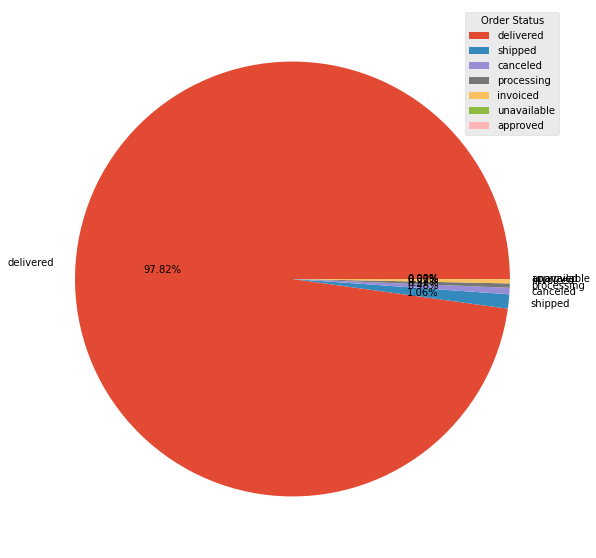

In [8]:

pieChart(olist_df['order_status'],"Order Status")


In [9]:
olist_df = olist_df[olist_df['order_status'] == 'delivered']
dropFtr(olist_df,['order_status'])
olist_df.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,2,146.87
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,1,275.79
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,1,275.79
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,7,140.61
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP,1,credit_card,10,137.58


#### Time and date related features explained
* order_estimated_delivery_date = Shows the estimated delivery date that was informed to customer at the purchase moment.
* order_delivered_customer_date = Shows the actual order delivery date to the customer.
* order_delivered_carrier_date = Shows the order posting timestamp. When it was handled to the logistic partner.
* shipping_limit_date = Shows the seller shipping limit date for handling the order over to the logistic partner.  ##
* order_approved_at = Shows the payment approval timestamp.
* order_purchase_timestamp = Shows the purchase timestamp.


#### Convert order related dates into datetime format from string format

In [10]:


olist_df['order_purchase_timestamp'] = pd.to_datetime(olist_df['order_purchase_timestamp'], format="%Y-%m-%d %H:%M:%S")
olist_df['order_approved_at'] = pd.to_datetime(olist_df['order_approved_at'], format="%Y-%m-%d %H:%M:%S")
olist_df['order_delivered_carrier_date']  = pd.to_datetime(olist_df['order_delivered_carrier_date'], format="%Y-%m-%d %H:%M:%S")
olist_df['order_delivered_customer_date'] = pd.to_datetime(olist_df['order_delivered_customer_date'], format="%Y-%m-%d %H:%M:%S")
olist_df['order_estimated_delivery_date'] = pd.to_datetime(olist_df['order_estimated_delivery_date'], format="%Y-%m-%d")
olist_df['shipping_limit_date'] = pd.to_datetime(olist_df['shipping_limit_date'], format="%Y-%m-%d %H:%M:%S")

# olist_df.dtypes

### Findout different time/day intervals between different time related features
* **approval_delay** is time difference between the purchase time of the product(**order_purchase_timestamp**) and the time taken to approve the order(**order_approved_at**) from the seller.
* **carrier_delay** is the time it was taken to be handled to the logistic partner(**order_delivered_carrier_date**) after its approval by the seller. (**order_approved_at**)
* **delivery_delay** is the time difference of the actual delivery time(**order_delivered_customer_date**) - the expected delivery date(**order_estimated_delivery_date**)
* **carrier_delay has some negative values those are not possible at all. I am going to filter out the negative values, that means it was handelted to the logistic partner before of its approval by the seller**
* **shipping_delay** is the time difference of the actual shipping handled time to the logistic partner(**order_delivered_carrier_date**) and the expected time to handle to the logistic partner(**shipping_limit_date**).


### Remove Null Rows

In [11]:
# Drop all null rows, as the number of null rows are very low

null_val = chkNull(olist_df)
print(null_val)


dropNullRows(olist_df)
    
null_val = chkNull(olist_df)
print(null_val)


6623
0


In [12]:

olist_df['approval_delay'] = (olist_df['order_approved_at'] - olist_df['order_purchase_timestamp']) / np.timedelta64(1,'D')

olist_df['delivery_delay'] = (olist_df['order_estimated_delivery_date'] - olist_df['order_delivered_customer_date'])/ np.timedelta64(1,'D')

olist_df['shipping_delay'] = (olist_df['shipping_limit_date'] - olist_df['order_delivered_carrier_date'])/ np.timedelta64(1,'D')


### Date Time Feature Analysis

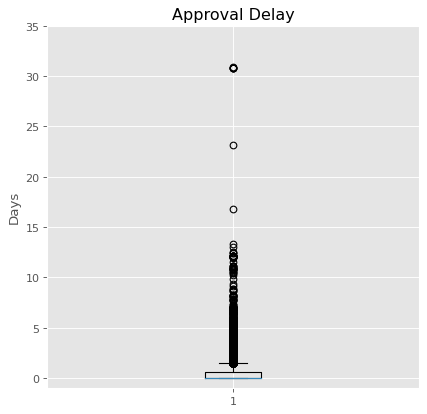

In [13]:
# Now I am going to draw some boxplots to find out outliers on the approval_delay, delivery_delay,shipping_delay. 
boxPlot(olist_df['approval_delay'],"Days","Approval Delay",-1,35)


Approval dely is time taken to **approve** the order after **purchasing** it by the customer. It seems that most of the orders around 75% of the orders are aproved by one/two days, while around 25% of the order takes more than two days to be approved. Here are some outliers and those tooks around more than 15 days to be approved. 

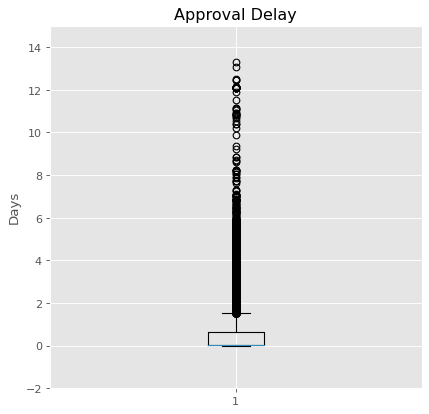

In [14]:
boxPlot(olist_df['approval_delay'],"Days","Approval Delay",-2,15)

After zooming the approval delay, it is obvious that most of the orders (around 75%) approved 1-2 days. 

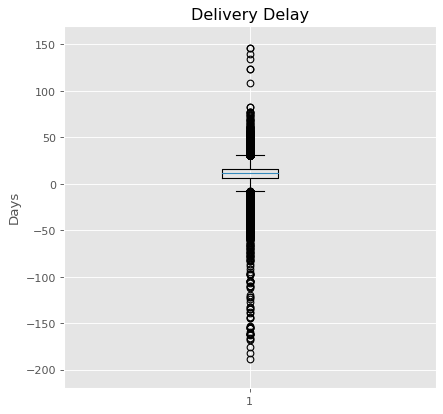

In [15]:
boxPlot(olist_df['delivery_delay'],"Days","Delivery Delay",-220,170)


delivery_delay is the time difference between the estimated delivery time and the actual delivery time. Some delivery delays have minus values that means those delivery reach their destination before deadline. Now I am going to zoom a bit to see what is time that most of the dilivery tooks. 

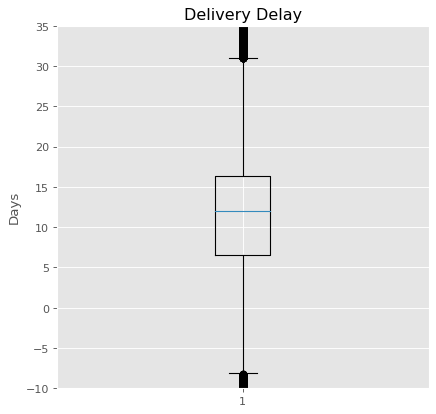

In [16]:
boxPlot(olist_df['delivery_delay'],"Days","Delivery Delay",-10,35)

It seems that around 50% of the delivery takes 5-15 ddays to reach its destinations.

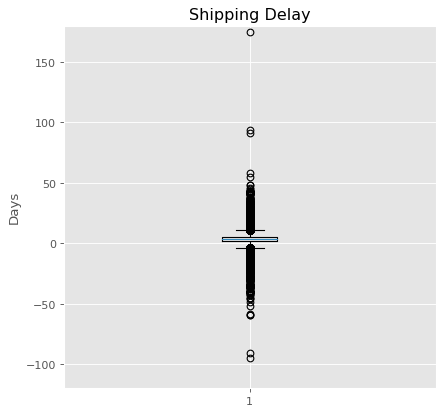

In [17]:
boxPlot(olist_df['shipping_delay'],"Days","Shipping Delay",-120,180)

* **shipping_delay** is the time difference of the actual shipping handled time to the logistic partner(**order_delivered_carrier_date**) and the expected time to handle to the logistic partner(**shipping_limit_date**). After analyzing the boxplot, it is evident that shipping_delay have some very large outliers. Some shipments takes more than 50 days to handle to the logistic partners. Some shipments tooks less than 100 days compared to estimated days to handle to the logistic partners. In my opinion it seems a bit noisy. Now I am going to zoom a bit to see what is the range that most of the shipping_delay takes.

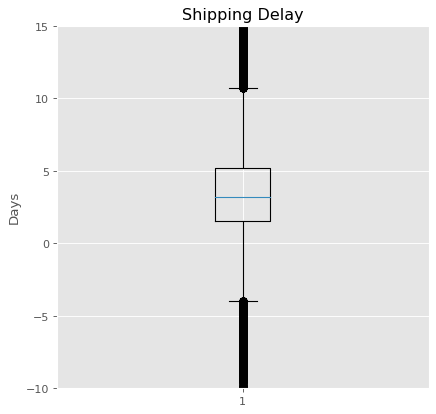

In [18]:
boxPlot(olist_df['shipping_delay'],"Days","Shipping Delay",-10,15)

around 50% of the sellers handle their product to their logistic partners within five days after the confirmation of the orders.

### Remove outliers based on date_time features

In [19]:
olist_df = olist_df[(olist_df['approval_delay'] < 15)]

olist_df = olist_df[(olist_df['delivery_delay'] < 50) & (olist_df['delivery_delay'] > -150)]

olist_df = olist_df[(olist_df['shipping_delay'] < 40) & (olist_df['shipping_delay'] > -50)]

#### Typically a order date related features contains five parts and those are year, month, day, hour and minute. I am going to deivide them into each five parts for modeling purposes.

In [20]:
olist_df['purchase_year'] = olist_df['order_purchase_timestamp'].dt.year
olist_df['purchase_month'] = olist_df['order_purchase_timestamp'].dt.month
olist_df['purchase_day'] = olist_df['order_purchase_timestamp'].dt.day
olist_df['purchase_hour'] = olist_df['order_purchase_timestamp'].dt.hour
olist_df['purchase_minute'] = olist_df['order_purchase_timestamp'].dt.minute

olist_df['approved_year'] = olist_df['order_approved_at'].dt.year
olist_df['approved_month'] = olist_df['order_approved_at'].dt.month
olist_df['approved_day'] = olist_df['order_approved_at'].dt.day
olist_df['approved_hour'] = olist_df['order_approved_at'].dt.hour
olist_df['approved_minute'] = olist_df['order_approved_at'].dt.minute

olist_df['delivered_carrier_year'] = olist_df['order_delivered_carrier_date'].dt.year
olist_df['delivered_carrier_month'] = olist_df['order_delivered_carrier_date'].dt.month
olist_df['delivered_carrier_day'] = olist_df['order_delivered_carrier_date'].dt.day
olist_df['delivered_carrier_hour'] = olist_df['order_delivered_carrier_date'].dt.hour
olist_df['delivered_carrier_minute'] = olist_df['order_delivered_carrier_date'].dt.minute

olist_df['delivered_customer_year'] = olist_df['order_delivered_customer_date'].dt.year
olist_df['delivered_customer_month'] = olist_df['order_delivered_customer_date'].dt.month
olist_df['delivered_customer_day'] = olist_df['order_delivered_customer_date'].dt.day
olist_df['delivered_customer_hour'] = olist_df['order_delivered_customer_date'].dt.hour
olist_df['delivered_customer_minute'] = olist_df['order_delivered_customer_date'].dt.minute

olist_df['estimated_delivery_year'] = olist_df['order_estimated_delivery_date'].dt.year
olist_df['estimated_delivery_month'] = olist_df['order_estimated_delivery_date'].dt.month


olist_df['shipping_limit_year'] = olist_df['shipping_limit_date'].dt.year
olist_df['shipping_limit_month'] = olist_df['shipping_limit_date'].dt.month
olist_df['shipping_limit_day'] = olist_df['shipping_limit_date'].dt.day
olist_df['shipping_limit_hour'] = olist_df['shipping_limit_date'].dt.hour
olist_df['shipping_limit_minute'] = olist_df['shipping_limit_date'].dt.minute

Now I am going to drop the following date_time features from olist_df
['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date']

In [21]:
ftr_need_to_drop = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
                    'order_estimated_delivery_date','shipping_limit_date']
dropFtr(olist_df,ftr_need_to_drop)

### Key Feature[late_delivery]
###### Here, late_delivery is my target feature. 
1.  **Date Time Features:** 
If it contains 1 then the late delivery status of the corresponding order is true, otherwise false

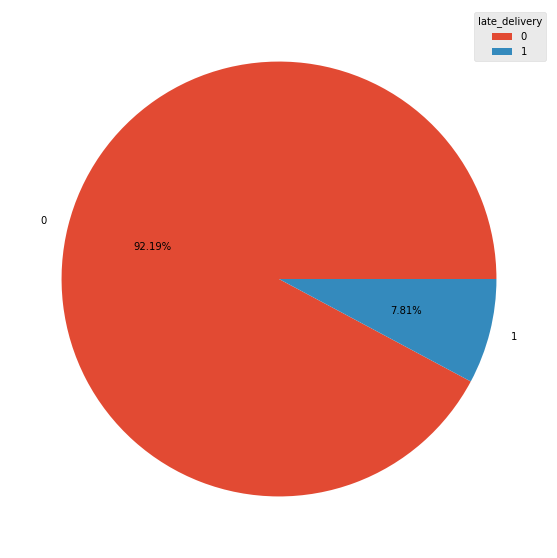

In [22]:
olist_df['late_delivery'] =   np.where(olist_df['delivery_delay'] < 0,1,0)

pieChart(olist_df['late_delivery'],"late_delivery")
# olist_df.head(5)

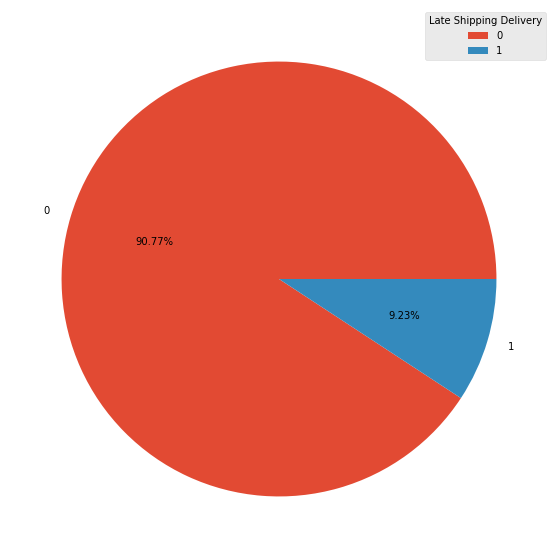

In [26]:
olist_df['late_shipping_delivery'] =   np.where(olist_df['shipping_delay'] < 0,1,0)

pieChart(olist_df['late_shipping_delivery'],"Late Shipping Delivery")

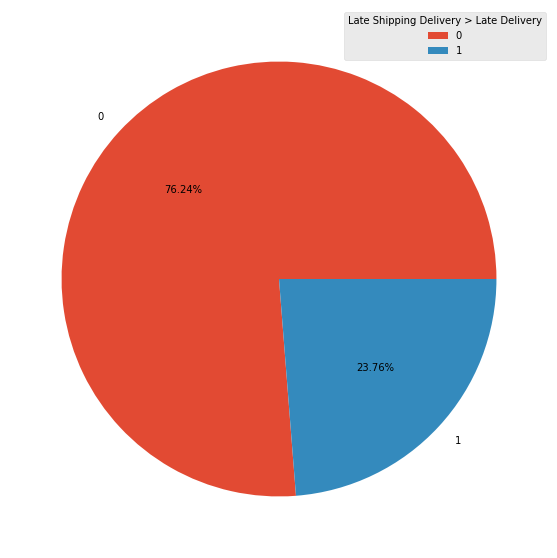

In [27]:
pieChart(olist_df[(olist_df['late_shipping_delivery']==1)]['late_delivery'],"Late Shipping Delivery > Late Delivery")

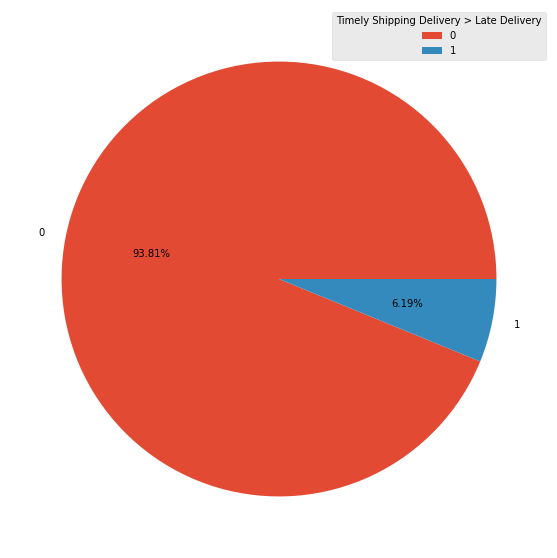

In [28]:
pieChart(olist_df[(olist_df['late_shipping_delivery']==0)]['late_delivery'],"Timely Shipping Delivery > Late Delivery")

<AxesSubplot:xlabel='purchase_year'>

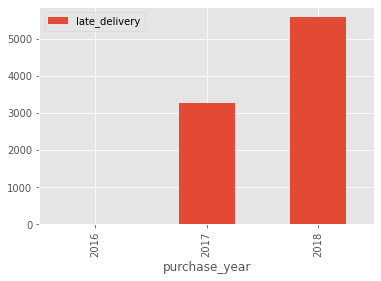

In [23]:
pivot_table = olist_df.pivot_table(
    values=['late_delivery'],index=['purchase_year'],aggfunc={'late_delivery':np.sum}
)
pivot_table.plot(kind="bar")

<AxesSubplot:xlabel='purchase_month'>

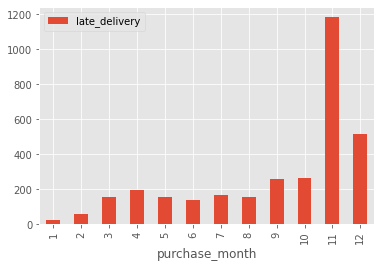

In [24]:
pivot_table = olist_df[(olist_df['purchase_year']==2017)].pivot_table(
    values=['late_delivery'],index=['purchase_month'],aggfunc={'late_delivery':np.sum}
)
pivot_table.plot(kind="bar")

<AxesSubplot:xlabel='purchase_month'>

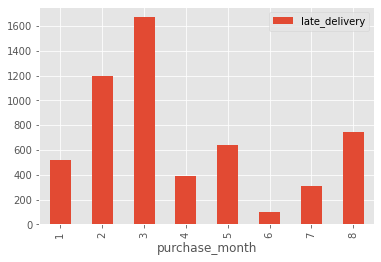

In [25]:
pivot_table = olist_df[(olist_df['purchase_year']==2018)].pivot_table(
    values=['late_delivery'],index=['purchase_month'],aggfunc={'late_delivery':np.sum}
)
pivot_table.plot(kind="bar")

### Payment Type Feature Analysis

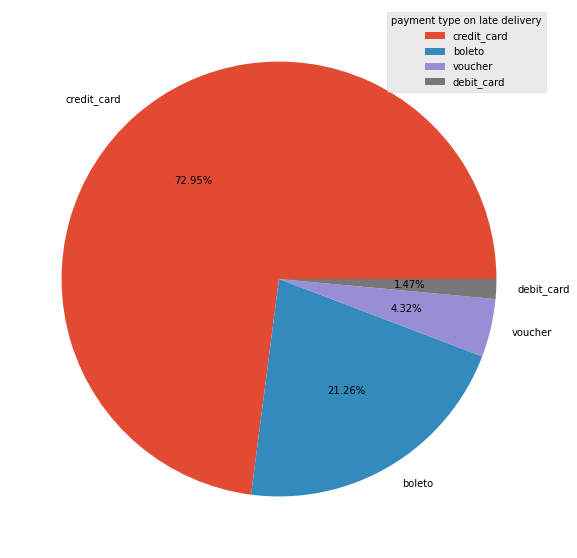

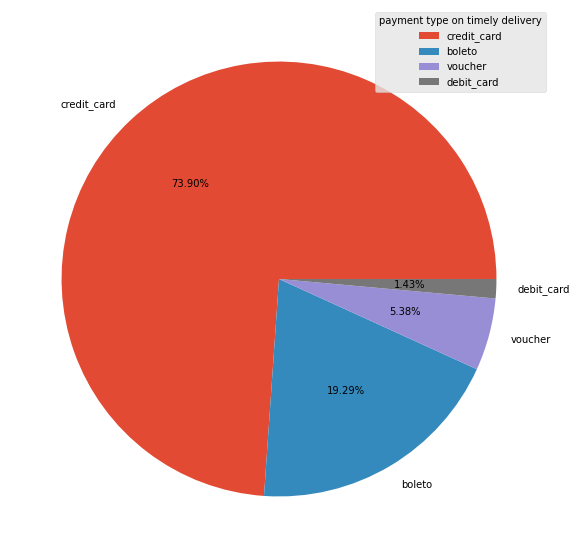

In [29]:
ctg_ftr = ['customer_state','seller_id','seller_state', 'product_category_name','customer_city', 'payment_type', 'seller_city']
                                                                
pieChart(olist_df[(olist_df['late_delivery'] == 1)]['payment_type'],"payment type on late delivery")
pieChart(olist_df[(olist_df['late_delivery'] ==0)]['payment_type'],"payment type on timely delivery")

#### use of voucher and credit_cart is slightly higher on timely_delivery while the use of boleto and debit_card is higher on late delivery

<AxesSubplot:xlabel='payment_installments'>

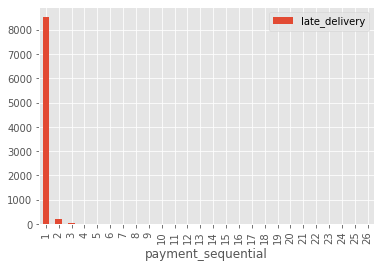

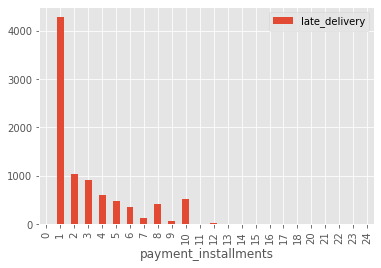

In [30]:
payment_sequential  = olist_df.pivot_table(
    values=['late_delivery'],index=['payment_sequential'],aggfunc={'late_delivery':np.sum}
)

payment_installments  = olist_df.pivot_table(
    values=['late_delivery'],index=['payment_installments'],aggfunc={'late_delivery':np.sum}
)


# payment_installments = olist_df['payment_installments'].unique()

payment_sequential.plot(kind="bar")
payment_installments.plot(kind="bar")

### Demographical Feature Analysis

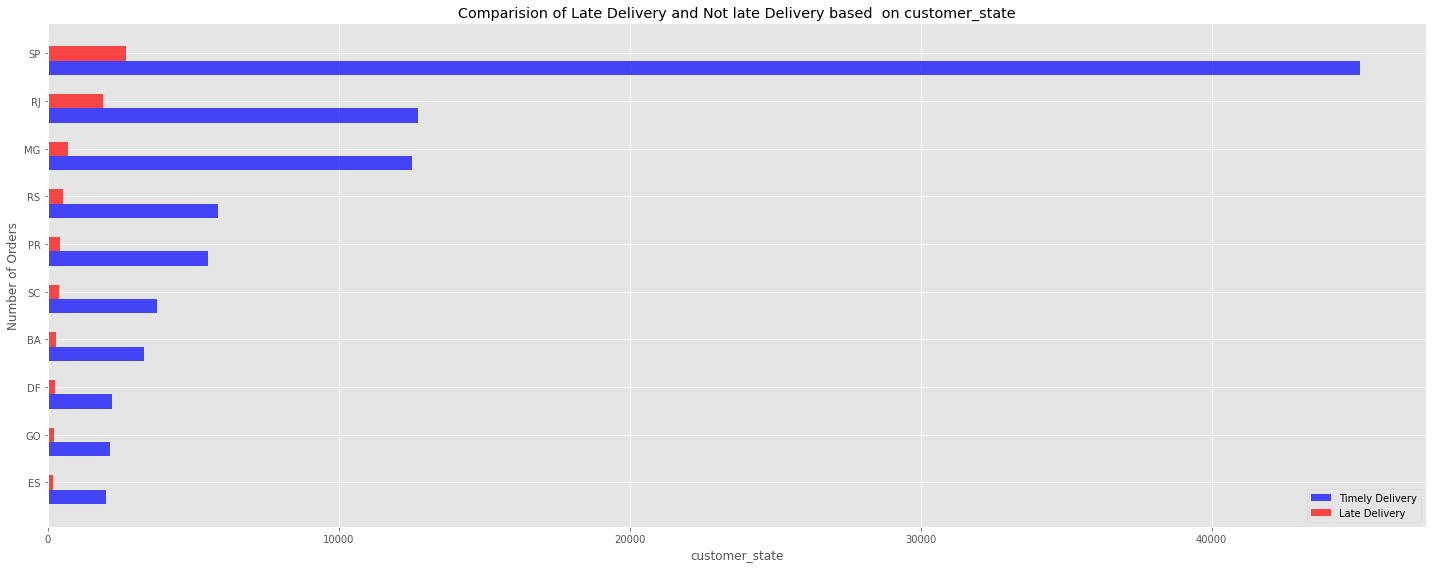

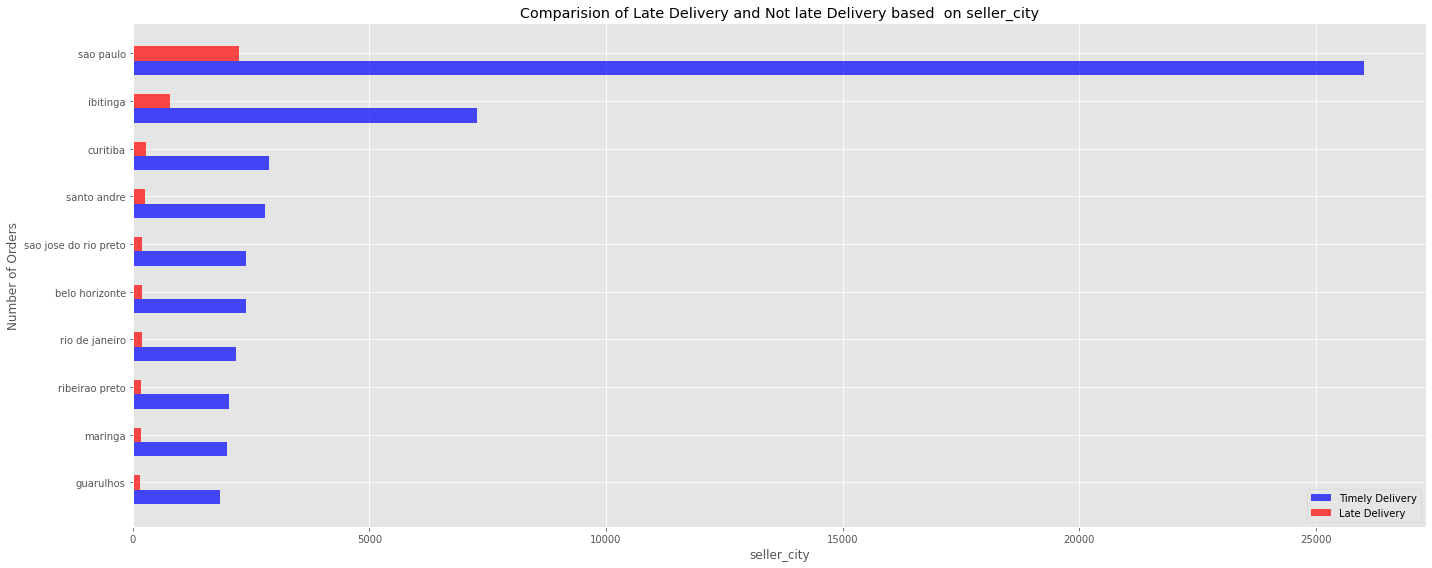

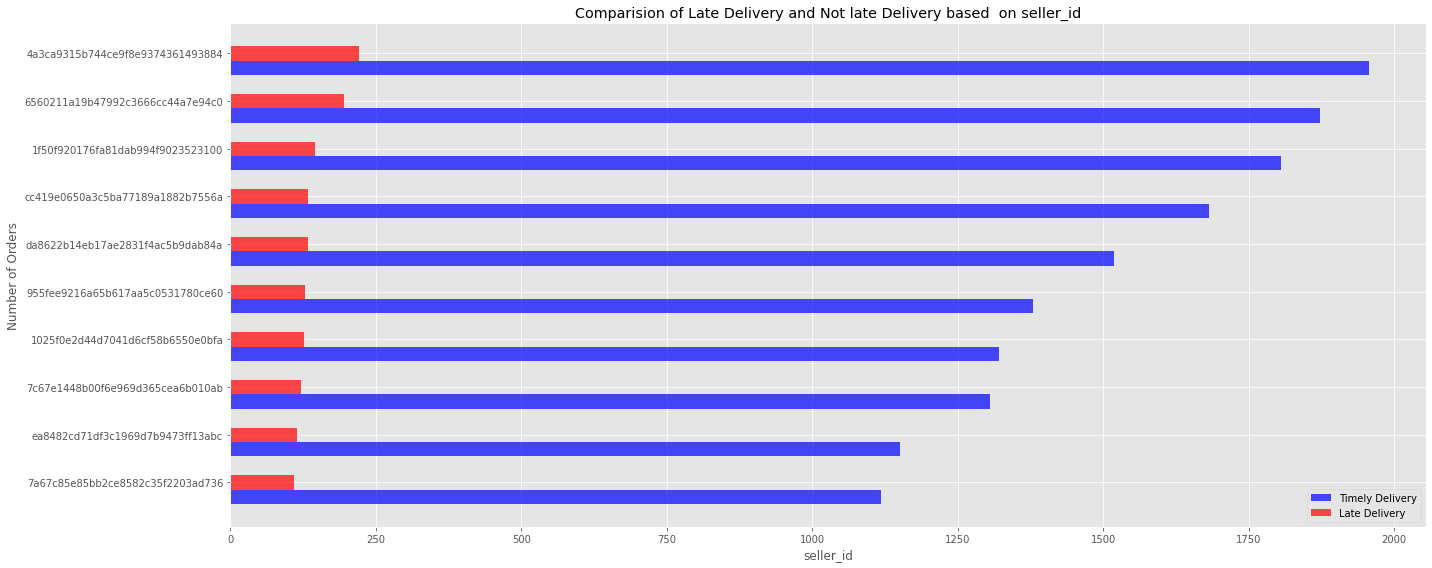

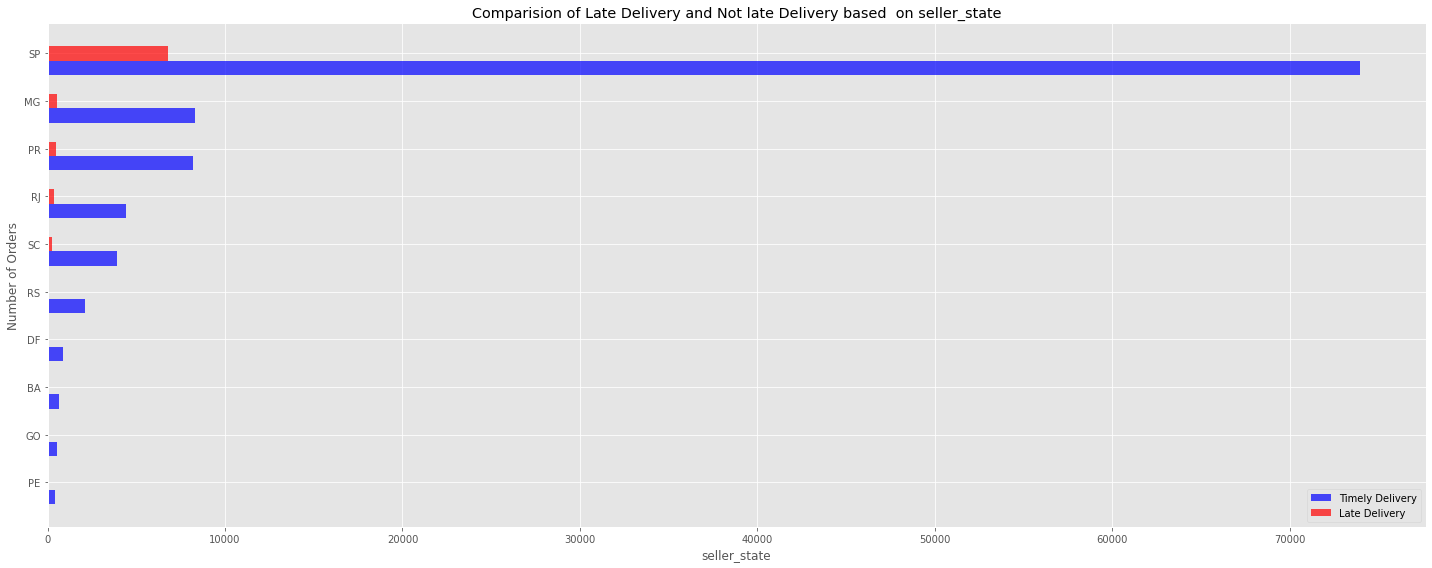

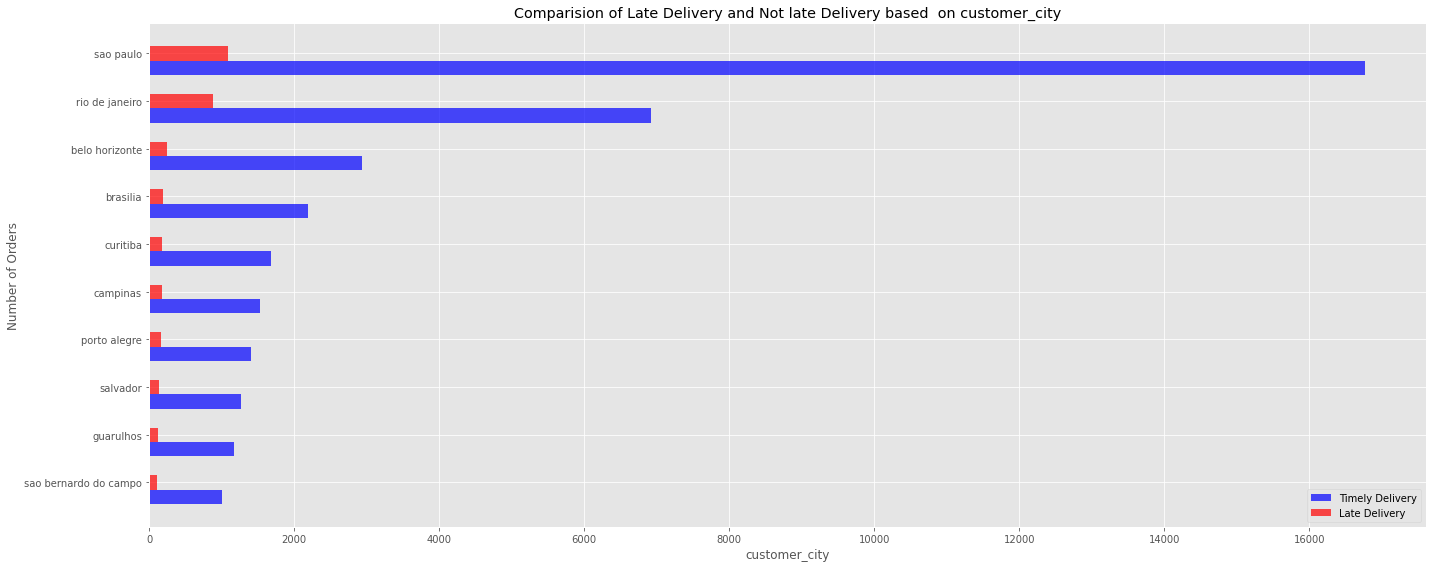

In [31]:
ctg_ftr = ['customer_state','seller_city','seller_id','seller_state','customer_city']

for ftr in ctg_ftr:
    cmpBarChart(ftr)



## Prepare important features for modeling purposes.

In [32]:

model_df = olist_df[[
'seller_id',
'approval_delay',
'shipping_delay',                 
'customer_zip_code_prefix',
 'customer_city',
 'customer_state', 
 'freight_value',
'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'payment_sequential',
 'payment_type',
 'payment_installments']].copy()

chkNull(model_df)
Y = olist_df['late_delivery'].copy()
Counter(Y)

Counter({0: 104360, 1: 8842})

### Check correlated features in model_df

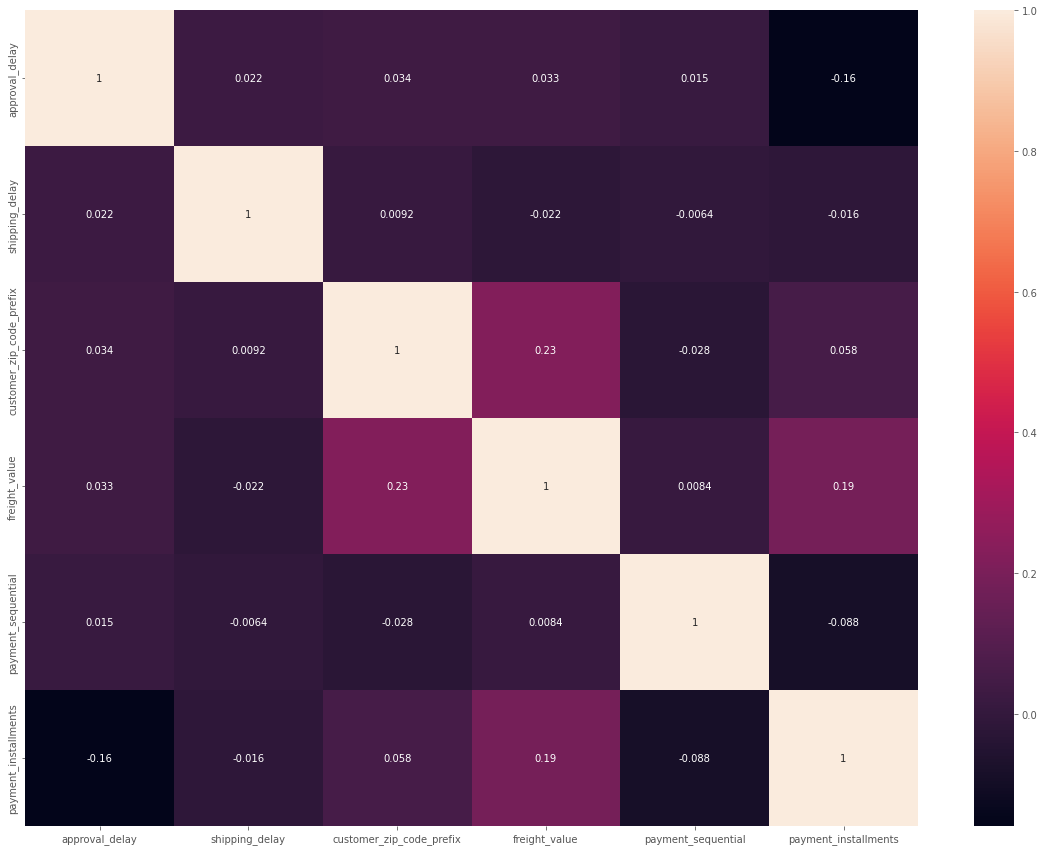

In [33]:
# I have drawn a heatmap to check highly correlated features in the model_df
heatMap(model_df)

### Heatmap Analysis
From analyzing the data above it is obvious that many of the features are highly correlated. Now I am going to plot the pair of highly correlated columns those threshold values are above certain level

In [34]:
# check the highly correlated features, those correlated are above .7
corr_matrix = corrFtr(model_df,.60)

corr_ftr = []
for i in range(len(corr_matrix.index)):
    if corr_matrix.index[i][1] not in corr_ftr:
        corr_ftr.append(corr_matrix.index[i][1])


Series([], dtype: float64)

In [35]:
# Remove the highly correlated features from model_df,


model_df.drop(corr_ftr,axis=1,inplace=True)
# Check the shape of the x,y features 
model_df_shape = model_df.shape
y_len = len(Y)

print(model_df_shape,y_len)

(113202, 13) 113202


### LeaveOneOutEncoder && Undersampling

In [36]:
model_df_ctg_ftr = getCtgCols(model_df)

encoder_ = LeaveOneOutEncoder(model_df_ctg_ftr)
model_df = encoder_.fit_transform(model_df,Y)

### Undersampling

In [37]:
# Undersample imbalanced dataset with NearMiss-1
undersample = NearMiss(version=1)
X,y = undersample.fit_resample(model_df,Y)

In [38]:
model_df_shape = X.shape
y_len = len(y)

print(model_df_shape,y_len)
Counter(y)

(17684, 13) 17684


Counter({0: 8842, 1: 8842})

## Modeling
### Split The Dataset for Training && Testing Purpose.

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=0)

### CART Classification 

In [40]:


model_crt = DecisionTreeClassifier(random_state=0)

model_crt.fit(x_train,y_train)
y_pred_crt = model_crt.predict(x_test)
score = r2_score(y_test,y_pred_crt)
print(score)

1.0


### Random Forest Classifier

In [41]:
model_rfc = RandomForestClassifier(random_state=0)

model_rfc.fit(x_train,y_train)
y_pred_rfc = model_rfc.predict(x_test)
score = r2_score(y_test,y_pred_rfc)
print(score)

0.9969843191415597


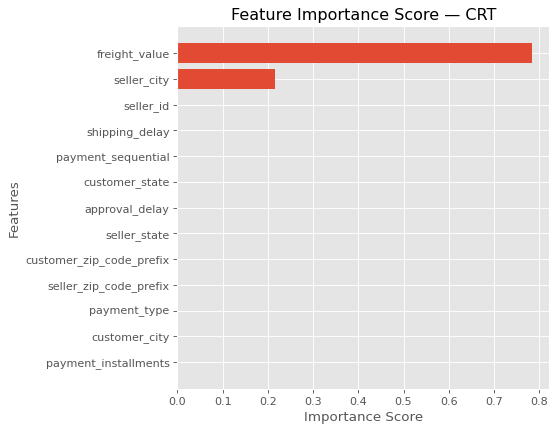

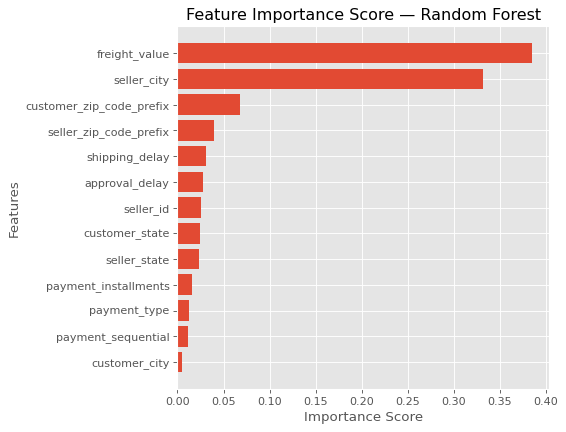

In [42]:
ftr_to_use = [
'seller_id',
'approval_delay',
'shipping_delay',           
'customer_zip_code_prefix',
 'customer_city',
 'customer_state', 
 'freight_value',
'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'payment_sequential',
 'payment_type',
 'payment_installments'
]

ftr_to_use = list(set(ftr_to_use) - set(corr_ftr))

chkFeatureImportance(model_crt,ftr_to_use,"Feature Importance Score — CRT")
chkFeatureImportance(model_rfc,ftr_to_use,"Feature Importance Score — Random Forest")


## Model Evaluation

Mean Squared Error:  0.00%
Mean Absolute Error:  0.00%
Accuracy:  100.00%


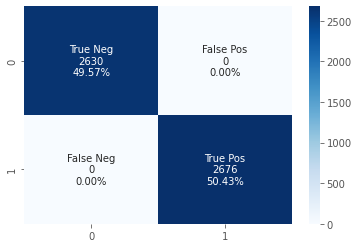

In [43]:
modelEva(y_test,y_pred_crt)
getConfusionMatrix(y_test,y_pred_crt)


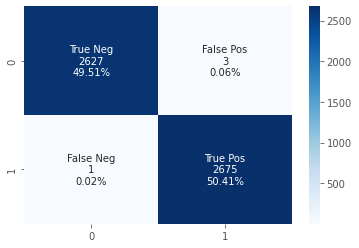

In [44]:
getConfusionMatrix(y_test,y_pred_rfc)